In [1]:
%load_ext lab_black

In [17]:
import collections
import json
import os
from itertools import product
from pathlib import Path
import sys

import numpy as np
from mne_bids.path import get_entities_from_fname
from natsort import natsorted
from rerf.rerfClassifier import rerfClassifier

# comparative classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier


from sklearn.calibration import calibration_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import brier_score_loss
from sklearn.metrics import roc_curve
from sklearn.preprocessing import OrdinalEncoder
from sklearn.utils import resample

sys.path.append("../")
# functions related to the feature comparison experiment
from analysis.publication.study import (
    load_patient_dict,
    determine_feature_importances,
    extract_Xy_pairs,
    format_supervised_dataset,
    _sequential_aggregation,
    tune_hyperparameters,
)
from analysis.publication.extract_datasets import load_ictal_frag_data
from analysis.publication.utils import NumpyEncoder

from sample_code.io import read_participants_tsv

%matplotlib inline
%load_ext autoreload
%autoreload 2

69
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Define Data Directories

In [18]:
# set seed and randomness for downstream reproducibility
seed = 12345
random_state = 12345
np.random.seed(seed)

# proportion of subjects to use for training
train_size = 0.6

# classification model to use
clf_type = "mtmorf"

# BIDS related directories
bids_root = Path("/Volumes/Seagate Portable Drive/data")
bids_root = Path("/Users/adam2392/Dropbox/epilepsy_bids/")
deriv_path = bids_root / "derivatives"
source_path = bids_root / "sourcedata"

# metadata table
excel_fpath = source_path / "organized_clinical_datasheet_raw.xlsx"

# where to store the cross-validation indices to split patients on
intermed_fpath = Path(deriv_path) / "baselinesliced"

# where to save results
study_path = Path(deriv_path) / "study"

# feature names
feature_names = [
    "fragility",
    # "delta",
    # "theta",
    # "alpha",
    # "beta",
    # "gamma",
    # "highgamma",
    # "correlation-degree",
    # "correlation-centrality",
    # 'delta-coherence-centrality', 'theta-coherence-centrality', 'alpha-coherence-centrality',
    # 'beta-coherence-centrality', 'gamma-coherence-centrality', 'highgamma-coherence-centrality',
    # "delta-coherence-degree",
    #'theta-coherence-degree', 'alpha-coherence-degree',
    #'beta-coherence-degree', 'gamma-coherence-degree',
    #     "highgamma-coherence-degree",
]

In [4]:
# defining evaluation criterion
metric = "roc_auc"
BOOTSTRAP = False

# define hyperparameters
windows = [
    (-80, 25),
]
thresholds = [
    0.5,
    0.6,
    0.7,
]
weighting_funcs = [None]

max_depth = [None, 5, 10]
max_features = ["auto", "log2"]
IMAGE_HEIGHT = 20
model_params = {
    "n_estimators": 500,
    "max_depth": max_depth[0],
    "max_features": max_features[0],
    "n_jobs": -1,
    "random_state": random_state,
}
model_params.update(
    {
        "projection_matrix": "S-RerF",
        "image_height": IMAGE_HEIGHT,
        "patch_height_max": 4,
        "patch_height_min": 1,
        "patch_width_max": 8,
        "patch_width_min": 1,
    }
)

# Define Classifiers

In [12]:
## Setup for run
names = {
    #     "Log. Reg": "blue",
    #     "Lin. SVM": "firebrick",
    #     "SVM": "purple",
    #     "kNN": "black",
    #     "RF": "#f86000",
    "MLP": "green",
    #     "S-RerF": "red",
    #          "MT-MORF": "orange"
}

ncores = -1
num_runs = 1
n_est = 500  # number of estimators

classifiers = [
    #     LogisticRegression(random_state=0, n_jobs=ncores, solver="liblinear"),
    #     LinearSVC(),
    #     SVC(C=1.0, probability=True, kernel="rbf", gamma="auto", random_state=0),
    #     KNeighborsClassifier(3, n_jobs=ncores),
    #     RandomForestClassifier(n_estimators=n_est, max_features="auto", n_jobs=ncores),
    MLPClassifier(hidden_layer_sizes=(n_est,), random_state=0, max_iter=1000),
    #     rerfClassifier(**model_params),
]

In [13]:
def combine_patient_predictions(
    ytrues, ypred_probs, subject_groups, pat_predictions=None, pat_true=None
):
    if pat_predictions is None or pat_true is None:
        pat_predictions = collections.defaultdict(list)
        pat_true = dict()

    # loop through things
    for ytrue, ypred_proba, subject in zip(ytrues, ypred_probs, subject_groups):
        pat_predictions[subject].append(float(ypred_proba))

        if subject not in pat_true:
            pat_true[subject] = ytrue[0]
        else:
            if pat_true[subject] != ytrue[0]:
                raise RuntimeError("wtf subject should all match...")
    return pat_predictions, pat_true

In [14]:
def load_data(
    feature_name,
    deriv_path,
    excel_fpath,
    patient_aggregation_method=None,
    intermed_fpath=None,
    save_cv_indices: bool = False,
):
    print(f"Loading data from {intermed_fpath}")
    # load unformatted datasets
    # i.e. datasets without data-hyperparameters applied
    if feature_name == "fragility":
        if not intermed_fpath:
            (
                unformatted_X,
                y,
                subject_groups,
                sozinds_list,
                onsetwin_list,
            ) = load_ictal_frag_data(deriv_path, excel_fpath=excel_fpath)
        else:
            (
                unformatted_X,
                y,
                subject_groups,
                sozinds_list,
                onsetwin_list,
            ) = load_ictal_frag_data(intermed_fpath, excel_fpath=excel_fpath)
    else:
        if not intermed_fpath:
            feature_subject_dict = load_patient_dict(
                deriv_path, feature_name, task="ictal", subjects=subjects
            )
            # get the (X, y) tuple pairs
            (
                unformatted_X,
                y,
                sozinds_list,
                onsetwin_list,
                subject_groups,
            ) = extract_Xy_pairs(
                feature_subject_dict,
                excel_fpath=excel_fpath,
                patient_aggregation_method=patient_aggregation_method,
                verbose=False,
            )
        else:
            # get the (X, y) tuple pairs
            feature_fpath = intermed_fpath / f"{feature_name}_unformatted.npz"

            with np.load(feature_fpath, allow_pickle=True) as data_dict:
                unformatted_X, y = data_dict["unformatted_X"], data_dict["y"]
                sozinds_list, onsetwin_list, subject_groups = (
                    data_dict["sozinds_list"],
                    data_dict["onsetwin_list"],
                    data_dict["subject_groups"],
                )
    # get the dataset parameters loaded in
    dataset_params = {"sozinds_list": sozinds_list, "onsetwin_list": onsetwin_list}

    # format supervised learning datasets
    # define preprocessing to convert labels/groups into numbers
    enc = OrdinalEncoder()  # handle_unknown='ignore', sparse=False
    #     subject_groups = enc.fit_transform(np.array(subjects)[:, np.newaxis])
    y = enc.fit_transform(np.array(y)[:, np.newaxis])
    subject_groups = np.array(subject_groups)

    # create held-out test dataset
    # create separate pool of subjects for testing dataset
    # 1. Cross Validation Training / Testing Split
    if save_cv_indices:
        gss = GroupShuffleSplit(n_splits=10, train_size=0.5, random_state=random_state)
        for jdx, (train_inds, test_inds) in enumerate(
            gss.split(unformatted_X, y, subject_groups)
        ):
            # if jdx != 7:
            #     continue
            train_pats = np.unique(subject_groups[train_inds])
            test_pats = np.unique(subject_groups[test_inds])
            np.savez_compressed(
                study_path / "inds" / f"{feature_name}-srerf-{jdx}-inds.npz",
                train_inds=train_inds,
                test_inds=test_inds,
                train_pats=train_pats,
                test_pats=test_pats,
            )
    return unformatted_X, y, subject_groups, dataset_params

In [15]:
def run_clf_validation(
    clf_type,
    clf_func,
    unformatted_X,
    y,
    subject_groups,
    dataset_params,
    study_path,
    windows,
    thresholds,
    weighting_funcs,
):
    #     if y.ndim != 1:
    #         y = y.copy().squeeze()
    #         y = y.copy[:, np.newaxis]

    unformatted_X = unformatted_X.copy()
    y = y.copy()
    subject_groups = subject_groups.copy()

    # store the cross validation nested scores per feature
    nested_scores = collections.defaultdict(list)

    # run this without the above for a warm start
    for jdx in range(0, 9):
        with np.load(
            # study_path / "inds" / 'clinical_complexity' / f"{jdx}-inds.npz",
            study_path
            / "inds"
            / "fixed_folds_subjects"
            / f"fragility-srerf-{jdx}-inds.npz",
            allow_pickle=True,
        ) as data_dict:
            # train_inds, test_inds = data_dict["train_inds"], data_dict["test_inds"]
            train_pats, test_pats = data_dict["train_pats"], data_dict["test_pats"]

        # set train indices based on which subjects
        train_inds = [
            idx for idx, sub in enumerate(subject_groups) if sub in train_pats
        ]
        test_inds = [idx for idx, sub in enumerate(subject_groups) if sub in test_pats]

        # note that training data (Xtrain, ytrain) will get split again
        # testing dataset (held out until evaluation)
        subjects_test = subject_groups[test_inds]
        print(subjects_test)

        if len(np.unique(y[test_inds])) == 1:
            print(f"Skipping group cv iteration {jdx} due to degenerate test set")
            continue

        tune_dataset_hyperparams = True
        if tune_dataset_hyperparams:
            # tune hyperparameters
            try:
                # create an iterator of all possible hyperparameters
                hyperparameters = product(windows, thresholds, weighting_funcs)

                master_scores = tune_hyperparameters(
                    clf_func,
                    unformatted_X=unformatted_X.copy(),
                    y=y.copy(),
                    groups=subject_groups.copy(),
                    train_inds=train_inds.copy(),
                    test_inds=test_inds.copy(),
                    hyperparameters=hyperparameters,
                    dataset_params=dataset_params,
                    **model_params,
                )
            except ValueError as e:
                print(jdx, e)
                continue

            print("Done tuning data hyperparameters...")
        else:
            window = windows[0]
            threshold = thresholds[0]
            weighting_func = weighting_funcs[0]
            X_formatted, dropped_inds = format_supervised_dataset(
                unformatted_X,
                **dataset_params,
                window=window,
                threshold=threshold,
                weighting_func=weighting_func,
            )

        # get the best classifier based on pre-chosen metric
        train_key = f"train_{metric}"
        test_key = f"test_{metric}"
        metric_list = [np.mean(scores[test_key]) for scores in master_scores]
        best_index = np.argmax(metric_list)

        # get the best estimator within that inner cv
        best_metric_ind = np.argmax(master_scores[best_index]["test_roc_auc"])
        best_estimator = master_scores[best_index]["estimator"][best_metric_ind]
        best_hyperparameter = master_scores[best_index]["hyperparameters"]
        best_window, best_threshold, _ = best_hyperparameter

        # apply formatting to the dataset
        X_formatted, dropped_inds = format_supervised_dataset(
            unformatted_X.copy(),
            **dataset_params,
            window=best_window,
            threshold=best_threshold,
            weighting_func=None,
        )

        # evaluate on the testing dataset
        X_test, y_test = np.array(X_formatted)[test_inds, ...], np.array(y)[test_inds]
        groups_test = np.array(subject_groups)[test_inds]

        # resample the held-out test data via bootstrap
        test_sozinds_list = np.asarray(dataset_params["sozinds_list"])[test_inds]
        test_onsetwin_list = np.asarray(dataset_params["onsetwin_list"])[test_inds]

        if BOOTSTRAP:
            for i in range(500):
                X_boot, y_boot, sozinds, onsetwins = resample(
                    X_test,
                    y_test,
                    test_sozinds_list,
                    test_onsetwin_list,
                    n_samples=len(y_test),
                )
        else:
            X_boot, y_boot = X_test.copy(), y_test.copy()

        y_pred = best_estimator.predict(X_boot)
        if "predict_proba" in dir(best_estimator):
            y_pred_prob = best_estimator.predict_proba(X_boot)[:, 1]
        else:
            y_pred_prob = y_pred

        # store analysis done on the validation group
        nested_scores["validate_groups"].append(groups_test)
        nested_scores["validate_subjects"].append(subjects_test)
        nested_scores["hyperparameters"].append(best_hyperparameter)

        if clf_type not in ["srerf", "mtmorf"]:
            nested_scores["estimator"].append(best_estimator)

        # store the actual outcomes and the predicted probabilities
        nested_scores["validate_ytrue"].append(list(y_test))
        nested_scores["validate_ypred_prob"].append(list(y_pred_prob))
        nested_scores["validate_ypred"].append(list(y_pred))

        # store ROC curve metrics on the held-out test set
        fpr, tpr, thresholds = roc_curve(y_boot, y_pred_prob, pos_label=1)
        fnr, tnr, neg_thresholds = roc_curve(y_boot, y_pred_prob, pos_label=0)
        nested_scores["validate_fpr"].append(list(fpr))
        nested_scores["validate_tpr"].append(list(tpr))
        nested_scores["validate_fnr"].append(list(fnr))
        nested_scores["validate_tnr"].append(list(tnr))
        nested_scores["validate_thresholds"].append(list(thresholds))

        print("Done analyzing ROC stats...")

        # run the feature importances
        # compute calibration curve
        fraction_of_positives, mean_predicted_value = calibration_curve(
            y_boot, y_pred_prob, n_bins=10, strategy="quantile"
        )
        clf_brier_score = np.round(
            brier_score_loss(y_boot, y_pred_prob, pos_label=np.array(y_boot).max()), 2
        )

        print("Done analyzing calibration stats...")

        # store ingredients for a calibration curve
        nested_scores["validate_brier_score"].append(float(clf_brier_score))
        nested_scores["validate_fraction_pos"].append(list(fraction_of_positives))
        nested_scores["validate_mean_pred_value"].append(list(mean_predicted_value))

        # store outputs to run McNemars test and Cochrans Q test
        # get the shape of a single feature "vector" / structure array
        pat_predictions, pat_true = combine_patient_predictions(
            y_boot, y_pred_prob, subjects_test
        )
        nested_scores["validate_pat_predictions"].append(pat_predictions)
        nested_scores["validate_pat_true"].append(pat_true)

        # store output for feature importances
        X_shape = X_boot[0].reshape((IMAGE_HEIGHT, -1)).shape
        if clf_type not in ["s-rerf", "mt-morf"]:
            n_jobs = -1
        else:
            n_jobs = 1
        results = determine_feature_importances(
            best_estimator, X_boot, y_boot, n_jobs=n_jobs
        )
        imp_std = results.importances_std
        imp_vals = results.importances_mean
        nested_scores["validate_imp_mean"].append(list(imp_vals))
        nested_scores["validate_imp_std"].append(list(imp_std))

        print("Done analyzing feature importances...")

        # save intermediate analyses
        clf_func_path = (
            study_path
            / "clf"
            / "comparison_classifiers"
            / f"{clf_type}_classifiers_{feature_name}_{jdx}.npz"
        )
        clf_func_path.parent.mkdir(exist_ok=True, parents=True)

        # nested CV scores
        nested_scores_fpath = (
            study_path
            / "comparison_classifiers"
            / f"study_nested_scores_{clf_type}_{feature_name}_{jdx}.json"
        )

        # save the estimators
        print(nested_scores.keys())
        if clf_type not in ["srerf", "mtmorf"]:
            estimators = nested_scores.pop("estimator")
            np.savez_compressed(clf_func_path, estimators=estimators)
        else:
            estimators = None

        # save all the master scores as a JSON file
        with open(nested_scores_fpath, "w") as fin:
            json.dump(nested_scores, fin, cls=NumpyEncoder)

        del master_scores
        del estimators
        del best_estimator

# Load Data and Run Classification Experiments

In [9]:
print(study_path)

/Users/adam2392/Dropbox/epilepsy_bids/derivatives/study


In [10]:
feature_name = "fragility"


unformatted_X, y, subject_groups, dataset_params = load_data(
    feature_name,
    deriv_path,
    excel_fpath,
    patient_aggregation_method=None,
    intermed_fpath=intermed_fpath,
    save_cv_indices=False,
)

Loading data from /Users/adam2392/Dropbox/epilepsy_bids/derivatives/baselinesliced
69
Got 94 subjects
Got  431  datasets.
Got  94  patients
dict_keys(['jh101', 'jh103', 'jh105', 'jh107', 'jh108', 'la00', 'la01', 'la02', 'la03', 'la04', 'la05', 'la06', 'la07', 'la08', 'la09', 'la10', 'la11', 'la12', 'la13', 'la15', 'la16', 'la17', 'la20', 'la21', 'la22', 'la23', 'la24', 'la27', 'la28', 'la29', 'la31', 'nl01', 'nl03', 'nl04', 'nl05', 'nl07', 'nl08', 'nl09', 'nl10', 'nl13', 'nl14', 'nl15', 'nl16', 'nl17', 'nl18', 'nl19', 'nl20', 'nl21', 'nl22', 'nl23', 'nl24', 'pt1', 'pt2', 'pt3', 'pt6', 'pt7', 'pt8', 'pt10', 'pt11', 'pt12', 'pt13', 'pt14', 'pt15', 'pt16', 'pt17', 'tvb1', 'tvb2', 'tvb5', 'tvb7', 'tvb8', 'tvb11', 'tvb12', 'tvb14', 'tvb17', 'tvb18', 'tvb19', 'tvb23', 'tvb27', 'tvb28', 'tvb29', 'umf001', 'umf002', 'umf003', 'umf004', 'umf005', 'ummc001', 'ummc002', 'ummc003', 'ummc004', 'ummc005', 'ummc006', 'ummc007', 'ummc008', 'ummc009'])
416 416 416 416 416


In [11]:
for clf_name, clf_func in zip(names, classifiers):
    run_clf_validation(
        clf_name,
        clf_func,
        unformatted_X,
        y,
        subject_groups,
        dataset_params,
        study_path,
        windows,
        thresholds,
        weighting_funcs,
    )
    break

['jh101' 'jh101' 'jh101' 'jh101' 'jh105' 'jh105' 'jh105' 'jh105' 'jh105'
 'jh105' 'jh105' 'jh105' 'jh105' 'jh105' 'la00' 'la02' 'la05' 'la05'
 'la05' 'la05' 'la05' 'la05' 'la05' 'la05' 'la05' 'la05' 'la05' 'la05'
 'la05' 'la05' 'la05' 'la09' 'la09' 'la12' 'la12' 'la12' 'la12' 'la12'
 'la12' 'la12' 'la12' 'la12' 'la15' 'la17' 'la20' 'la20' 'la20' 'la20'
 'la20' 'la20' 'la20' 'la20' 'la21' 'la21' 'la21' 'la21' 'la21' 'la23'
 'la23' 'la23' 'la24' 'la24' 'la24' 'la27' 'la27' 'la27' 'la27' 'la27'
 'la27' 'la27' 'la27' 'la27' 'la27' 'la27' 'la27' 'la27' 'la27' 'la27'
 'la27' 'la27' 'la27' 'la27' 'la27' 'la27' 'la27' 'la27' 'la27' 'la27'
 'la28' 'la28' 'la28' 'la28' 'la28' 'la28' 'la28' 'la28' 'la28' 'la29'
 'la29' 'la29' 'la29' 'la29' 'nl01' 'nl01' 'nl01' 'nl04' 'nl04' 'nl04'
 'nl05' 'nl05' 'nl05' 'nl08' 'nl08' 'nl08' 'nl10' 'nl10' 'nl10' 'nl14'
 'nl14' 'nl14' 'nl14' 'nl14' 'nl14' 'nl15' 'nl15' 'nl15' 'nl17' 'nl17'
 'nl17' 'nl17' 'nl17' 'nl20' 'nl20' 'nl20' 'nl20' 'nl21' 'nl21' 'nl21'
 'nl21

/Users/adam2392/opt/miniconda3/envs/eztrack/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Done analyzing ROC stats...
Done analyzing calibration stats...
Done analyzing feature importances...
dict_keys(['validate_groups', 'validate_subjects', 'hyperparameters', 'estimator', 'validate_ytrue', 'validate_ypred_prob', 'validate_ypred', 'validate_fpr', 'validate_tpr', 'validate_fnr', 'validate_tnr', 'validate_thresholds', 'validate_brier_score', 'validate_fraction_pos', 'validate_mean_pred_value', 'validate_pat_predictions', 'validate_pat_true', 'validate_imp_mean', 'validate_imp_std'])
['jh101' 'jh101' 'jh101' 'jh101' 'la02' 'la06' 'la06' 'la06' 'la07' 'la07'
 'la07' 'la07' 'la08' 'la08' 'la08' 'la10' 'la10' 'la12' 'la12' 'la12'
 'la12' 'la12' 'la12' 'la12' 'la12' 'la12' 'la13' 'la13' 'la13' 'la20'
 'la20' 'la20' 'la20' 'la20' 'la20' 'la20' 'la20' 'la21' 'la21' 'la21'
 'la21' 'la21' 'la22' 'la22' 'la22' 'la22' 'la22' 'la27' 'la27' 'la27'
 'la27' 'la27' 'la27' 'la27' 'la27' 'la27' 'la27' 'la27' 'la27' 'la27'
 'la27' 'la27' 'la27' 'la27' 'la27' 'la27' 'la27' 'la27' 'la27' 'la27'


/Users/adam2392/opt/miniconda3/envs/eztrack/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Done analyzing ROC stats...
Done analyzing calibration stats...
Done analyzing feature importances...
dict_keys(['validate_groups', 'validate_subjects', 'hyperparameters', 'validate_ytrue', 'validate_ypred_prob', 'validate_ypred', 'validate_fpr', 'validate_tpr', 'validate_fnr', 'validate_tnr', 'validate_thresholds', 'validate_brier_score', 'validate_fraction_pos', 'validate_mean_pred_value', 'validate_pat_predictions', 'validate_pat_true', 'validate_imp_mean', 'validate_imp_std', 'estimator'])
['jh103' 'jh103' 'jh103' 'jh105' 'jh105' 'jh105' 'jh105' 'jh105' 'jh105'
 'jh105' 'jh105' 'jh105' 'jh105' 'la00' 'la02' 'la04' 'la06' 'la06' 'la06'
 'la07' 'la07' 'la07' 'la07' 'la08' 'la08' 'la08' 'la10' 'la10' 'la12'
 'la12' 'la12' 'la12' 'la12' 'la12' 'la12' 'la12' 'la12' 'la16' 'la17'
 'la22' 'la22' 'la22' 'la22' 'la22' 'la27' 'la27' 'la27' 'la27' 'la27'
 'la27' 'la27' 'la27' 'la27' 'la27' 'la27' 'la27' 'la27' 'la27' 'la27'
 'la27' 'la27' 'la27' 'la27' 'la27' 'la27' 'la27' 'la27' 'la27' 'la27

/Users/adam2392/opt/miniconda3/envs/eztrack/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Done analyzing ROC stats...
Done analyzing calibration stats...
Done analyzing feature importances...
dict_keys(['validate_groups', 'validate_subjects', 'hyperparameters', 'validate_ytrue', 'validate_ypred_prob', 'validate_ypred', 'validate_fpr', 'validate_tpr', 'validate_fnr', 'validate_tnr', 'validate_thresholds', 'validate_brier_score', 'validate_fraction_pos', 'validate_mean_pred_value', 'validate_pat_predictions', 'validate_pat_true', 'validate_imp_mean', 'validate_imp_std', 'estimator'])
['jh103' 'jh103' 'jh103' 'jh105' 'jh105' 'jh105' 'jh105' 'jh105' 'jh105'
 'jh105' 'jh105' 'jh105' 'jh105' 'la02' 'la04' 'la07' 'la07' 'la07' 'la07'
 'la09' 'la09' 'la11' 'la11' 'la13' 'la13' 'la13' 'la16' 'la17' 'la20'
 'la20' 'la20' 'la20' 'la20' 'la20' 'la20' 'la20' 'la22' 'la22' 'la22'
 'la22' 'la22' 'la23' 'la23' 'la23' 'la24' 'la24' 'la24' 'la29' 'la29'
 'la29' 'la29' 'la29' 'la31' 'la31' 'la31' 'la31' 'la31' 'la31' 'la31'
 'nl01' 'nl01' 'nl01' 'nl03' 'nl03' 'nl03' 'nl08' 'nl08' 'nl08' 'nl09

/Users/adam2392/opt/miniconda3/envs/eztrack/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Done analyzing ROC stats...
Done analyzing calibration stats...
Done analyzing feature importances...
dict_keys(['validate_groups', 'validate_subjects', 'hyperparameters', 'validate_ytrue', 'validate_ypred_prob', 'validate_ypred', 'validate_fpr', 'validate_tpr', 'validate_fnr', 'validate_tnr', 'validate_thresholds', 'validate_brier_score', 'validate_fraction_pos', 'validate_mean_pred_value', 'validate_pat_predictions', 'validate_pat_true', 'validate_imp_mean', 'validate_imp_std', 'estimator'])
['jh101' 'jh101' 'jh101' 'jh101' 'jh103' 'jh103' 'jh103' 'jh108' 'jh108'
 'jh108' 'jh108' 'jh108' 'jh108' 'la00' 'la02' 'la03' 'la03' 'la03' 'la03'
 'la03' 'la03' 'la03' 'la03' 'la03' 'la03' 'la03' 'la03' 'la03' 'la03'
 'la04' 'la06' 'la06' 'la06' 'la07' 'la07' 'la07' 'la07' 'la11' 'la11'
 'la15' 'la17' 'la21' 'la21' 'la21' 'la21' 'la21' 'la22' 'la22' 'la22'
 'la22' 'la22' 'la24' 'la24' 'la24' 'la27' 'la27' 'la27' 'la27' 'la27'
 'la27' 'la27' 'la27' 'la27' 'la27' 'la27' 'la27' 'la27' 'la27' 'la27

/Users/adam2392/opt/miniconda3/envs/eztrack/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Done analyzing ROC stats...
Done analyzing calibration stats...
Done analyzing feature importances...
dict_keys(['validate_groups', 'validate_subjects', 'hyperparameters', 'validate_ytrue', 'validate_ypred_prob', 'validate_ypred', 'validate_fpr', 'validate_tpr', 'validate_fnr', 'validate_tnr', 'validate_thresholds', 'validate_brier_score', 'validate_fraction_pos', 'validate_mean_pred_value', 'validate_pat_predictions', 'validate_pat_true', 'validate_imp_mean', 'validate_imp_std', 'estimator'])
['jh105' 'jh105' 'jh105' 'jh105' 'jh105' 'jh105' 'jh105' 'jh105' 'jh105'
 'jh105' 'jh108' 'jh108' 'jh108' 'jh108' 'jh108' 'jh108' 'la00' 'la01'
 'la02' 'la03' 'la03' 'la03' 'la03' 'la03' 'la03' 'la03' 'la03' 'la03'
 'la03' 'la03' 'la03' 'la03' 'la03' 'la05' 'la05' 'la05' 'la05' 'la05'
 'la05' 'la05' 'la05' 'la05' 'la05' 'la05' 'la05' 'la05' 'la05' 'la05'
 'la08' 'la08' 'la08' 'la10' 'la10' 'la12' 'la12' 'la12' 'la12' 'la12'
 'la12' 'la12' 'la12' 'la12' 'la13' 'la13' 'la13' 'la20' 'la20' 'la20'
 '

KeyboardInterrupt: 

# Read in the Participants.tsv File Containing Clinical Metadata

The participants.tsv file contains clinical metadata. Let's get the clinical success rate of our dataset
and total success/failure counts.

In [21]:
pat_df = read_participants_tsv(bids_root)
subjects = pat_df["participant_id"]
display(pat_df.head())

,participant_id,age,sex,hand,outcome,engel_score,ilae_score,date_follow_up,ethnicity,years_follow_up,site,clinical_complexity
0,sub-jh101,NaN,NaN,NaN,F,4.0,6.0,NaN,NaN,1.0,JHH,4.0
1,sub-jh102,NaN,NaN,NaN,NR,-1.0,-1.0,NaN,NaN,1.0,JHH,4.0
2,sub-jh103,NaN,NaN,NaN,F,4.0,6.0,NaN,NaN,1.0,JHH,3.0
3,sub-jh104,NaN,NaN,NaN,NR,-1.0,-1.0,NaN,NaN,1.0,JHH,3.0
4,sub-jh105,NaN,NaN,NaN,S,1.0,1.0,NaN,NaN,1.0,JHH,2.0


In [22]:
outcomes = []

# get a list of all the outcomes
for subj in np.unique(subjects):
    # use excel file to set various data points
    pat_row = pat_df[pat_df['participant_id'] == 'sub-' + subj]
    outcomes.append(pat_row['outcome'].values[0])
print(outcomes)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
n_success = len(np.argwhere(np.array(outcomes) == 'S'))
clinical_sensitivity = n_success / len(outcomes)
clinical_fpr = (len(outcomes) - n_success) / len(outcomes)

print(f'Clinical sensitivity: {clinical_sensitivity}')
print(f'Clinical False Positive Rate: {clinical_fpr}')

# Plotting Comparisons

In [16]:
# identifying strings for each feature representation of the data
feature_name = 'fragility'

## Setup for run
names = {
        "Log. Reg": "blue",
    "Lin. SVM": "firebrick",
    "SVM": "purple",
#     "kNN": "black",
    "RF": "#f86000",
    "MLP": "green",
#     "S-RerF": "red",
    "mtmorf": "orange"
}

clf_type = 'mtmorf'

study_path = deriv_path

In [17]:
# dictionary data structure to hold all the CV experiment results
nested_scores_feature = dict()

for clf_name in names:
    # nested CV estimators
    nested_scores_search_pattern = f'study_nested_scores_{clf_name}_{feature_name}_*.json'
    nested_scores = None
    
    # get all json files that follow that search pattern
    fpaths = (study_path / 'comparison_classifiers').glob(nested_scores_search_pattern)
    fpaths = natsorted(fpaths)
    for json_fpath in fpaths:
        with open(json_fpath, 'r') as fin:
            _nested_scores = json.load(fin)
        
        # either append to the nested dictionary, or create it
        # some magic done to cast numbers in case they were saved in different formats
        if nested_scores is None:
            for key, val in _nested_scores.items():
                if key in ['validate_ytrue']:
                    val = val[0]
                    for idx, y in enumerate(val):
                        val[idx] = y[0]
                else:
                    continue
            nested_scores = _nested_scores
        else:
            for key, val in _nested_scores.items():
                if key == 'validate_ytrue':
                    val = val[0]
                    for idx, y in enumerate(val):
                        val[idx] = y[0]
                nested_scores[key].append(np.array(val).squeeze()) 
    print(f'There should be 10 total CV for {clf_name}. We found {len(fpaths)}')
    nested_scores_feature[clf_name] = nested_scores

There should be 10 total CV for fragility. We found 10
There should be 10 total CV for delta. We found 10
There should be 10 total CV for theta. We found 10
There should be 10 total CV for alpha. We found 10
There should be 10 total CV for beta. We found 10
There should be 10 total CV for gamma. We found 10
There should be 10 total CV for highgamma. We found 10
There should be 10 total CV for correlation-degree. We found 10
There should be 10 total CV for correlation-centrality. We found 10
There should be 10 total CV for delta-coherence-centrality. We found 10
There should be 10 total CV for theta-coherence-centrality. We found 10
There should be 10 total CV for alpha-coherence-centrality. We found 10
There should be 10 total CV for beta-coherence-centrality. We found 10
There should be 10 total CV for gamma-coherence-centrality. We found 10
There should be 10 total CV for highgamma-coherence-centrality. We found 10
There should be 10 total CV for delta-coherence-degree. We found 10
T

In [28]:
auc_feat_names = []
auc_feat_scores = []

for name, nested_scores in nested_scores_feature.items():
    # summarize the boot-strapped samples
    fprs, tprs = nested_scores['validate_fpr'], nested_scores['validate_tpr']
    # aucs = [auc(fpr, tpr) for fpr, tpr in zip(fprs, tprs)]
    mean_fpr, tprs, aucs = average_roc(fprs, tprs)
    mean_tpr, std_tpr = np.mean(tprs, axis=0), np.std(tprs, axis=0)
    
    auc_feat_names.append(name)
    auc_feat_scores.append(np.mean(aucs))
    
auc_sorted_inds = np.argsort(auc_feat_scores)[::-1]
print(np.array(auc_feat_names)[auc_sorted_inds])

Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
['fragility' 'beta' 'beta-coherence-centrality' 'alpha'
 'theta-coherence-centrality' 'alpha-coherence-centrality' 'gamma'
 'gamma-coherence-centrality' 'theta'

In [57]:
# store all AUCs and Average Precision metrics
feature_aucs = dict()
feature_prs = dict()
feature_pred_names = []
feature_pred_probs = []
feature_pred_subs = []

# show some summary statements?
verbose = False

Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits


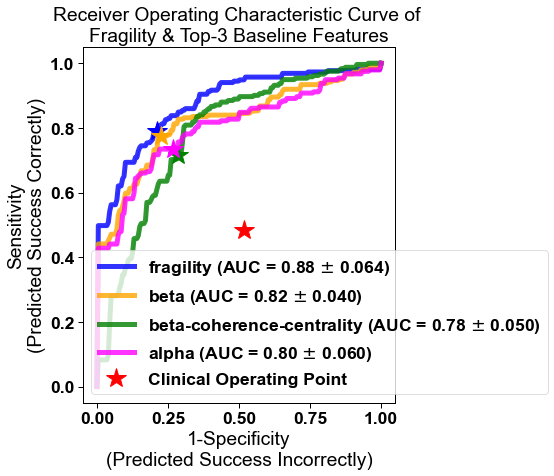

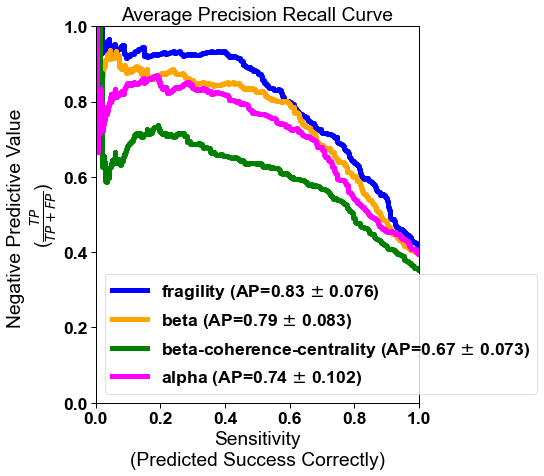

In [58]:
sns.set_context('paper', font_scale=2.0)

# figure to show ROC
fig, ax = plt.subplots(1, 1, figsize=(7,7))

# figure to show Precision plot
pfig, pax = plt.subplots(figsize=(7,7))

# color scheme
colors = ['blue', 'orange', 'green', 'magenta', 'black']

# for idx, (feature_name, nested_scores) in enumerate(nested_scores_feature.items()):
for idx in range(len(auc_feat_names)):
    # extract the feature name for plotting
    feature_name = np.asarray(auc_feat_names)[auc_sorted_inds][idx]
    
    # get the test set performances for this feature
    nested_scores = nested_scores_feature[feature_name]
    
    # extract the predicted probability of success, the true outcomes
    # for each 10 fold CV
    pat_predict_proba = nested_scores['validate_pat_predictions']
    pat_true = nested_scores['validate_pat_true']
    
    # initialize lists to store certain metrics we want to keep track of
    fprs = []
    tprs = []
    accs = []
    aps = []
    npvs = []
    ppvs = []
    ratio_succ = []
    ratio_fail = []
    n_succ = []
    n_fail = []
    
    # for visual sake only show the top 3 performing based on average AUC
    if idx > 3:
        idx = 4
    color = colors[idx]
    
    # loop through each CV fold (10 in total)
    for jdx in range(len(pat_true)):
        # in case data was stored in different formats, just pull them out
        # byproduct of saving w/ different encoding...
        if isinstance(pat_true[jdx], dict):
            pat_trues = pat_true[jdx]
            pat_predicts = pat_predict_proba[jdx]
        else:
            pat_trues = pat_true[jdx].item()
            pat_predicts = pat_predict_proba[jdx].item()
        
        # keep each patient's probability of success prediction, true outcome and list
        # of subjects in the test dataset
        pat_proba = []
        pat_y = []
        subjects = []
        for patient, pat_y_true in pat_trues.items():
            pat_probas = pat_predicts[patient]
            pat_mean_proba = np.mean(np.array(pat_probas).squeeze())

            pat_proba.append(pat_mean_proba)
            pat_y.append(pat_y_true)
            subjects.append(patient)
            
        # set the patient predictions based on the success probability prediction
        pat_predictions = np.where(np.array(pat_proba) > 0.5, 1, 0)
        
        # compute a balanced accuracy score of the predicted outcomes vs true outcomes
        acc = balanced_accuracy_score(pat_y, pat_predictions)
        
        # compute the number of failures/success per CV fold and the ratio of each
        n_true_succ = len([y_ for y_, ytrue_ in zip(pat_predictions, pat_y) if ytrue_ == 1])
        n_true_fail = len([y_ for y_, ytrue_ in zip(pat_predictions, pat_y) if ytrue_ == 0])
        num_fail = len([y_ for y_, ytrue_ in zip(pat_predictions, pat_y) if y_ == ytrue_ if ytrue_ == 0])
        num_success = len([y_ for y_, ytrue_ in zip(pat_predictions, pat_y) if y_ == ytrue_ if ytrue_ == 1])
        ratio_fail.append(num_fail / n_true_fail)
        ratio_succ.append(num_success / n_true_succ)
        n_fail.append(n_true_fail)
        n_succ.append(n_true_succ)
        
        # compute now the sensitivity, specificity, PPV, and NPV statistics
        sensitivity, specificity, pos_pred_val, neg_pred_val = perf_metrics_2X2(
            np.array(pat_y), np.array(pat_predictions))
        npvs.append(neg_pred_val)
        ppvs.append(pos_pred_val)
        
        # compute the average precision of the test-set predictions
#         average_precision = average_precision_score(pat_y, pat_proba, pos_label=0, average=None)
#         aps.append(average_precision)
        
        # create the roc curve on this fold
        fpr, tpr, thresholds = roc_curve(pat_y, pat_proba)
        fprs.append(fpr)
        tprs.append(tpr)
        accs.append(acc)
        
        # store the subjects, predicted probabilities and feature names
        feature_pred_subs.extend(subjects)
        feature_pred_probs.extend(pat_proba)
        feature_pred_names.extend([feature_name] * len(pat_proba))

    ytrues, ypreds = nested_scores['validate_ytrue'], nested_scores['validate_ypred_prob']
    if verbose:
        ### Now compute statistics for summary, such as accuracies, f1scores, 
        accs = []
        f1s = []
        for ytrue, ypred in zip(ytrues, ypreds):
            ytrue = np.array(ytrue).squeeze()
            ypred = np.array(ypred).squeeze()
            ypred = np.array(ypred) > 0.5
            acc = balanced_accuracy_score(ytrue, ypred)
            f1score = f1_score(ytrue, ypred)
            accs.append(acc)
            f1s.append(f1score)
        
        print(f'\n\n{feature_name}')
        print(f'Balanced accuracy score: {np.mean(accs):.2f} +/- {np.std(accs):.2f}')
        print(f'F1 score: {np.mean(f1s):.2f} +/- {np.std(f1s):.2f}')
        print(f'Sensitivity: {youden_point[1]} and FPR: {youden_point[0]}')
        print('Improvement in FPR: ', np.round(youden_point[0]-clinical_fpr, 2))
        print('Improvement in TPR: ', np.round(youden_point[1]-clinical_sensitivity, 2))
        print('Total distance: ', np.linalg.norm((youden_point[0]-clinical_fpr, youden_point[1]-clinical_sensitivity)))
        print(f'Average Preicions: {np.mean(aps):.3f} +/- {np.std(aps):.3f}')
        print(f'Average NPVS: {np.mean(npvs):.3f} +/- {np.std(npvs):.3f}')
        print(f'Average PPVS: {np.mean(ppvs):.3f} +/- {np.std(ppvs):.3f}')
        print(f'Average failed ratio: {np.mean(ratio_fail):.3f} +/- {np.std(ratio_fail):.3f}')    
        print(f'Average success ratio: {np.mean(ratio_succ):.3f} +/- {np.std(ratio_succ):.3f}')    
    
        
    # compute the average ROC curve from the above loop over nested CV
    mean_fpr, tprs, aucs = average_roc(fprs, tprs)
    mean_tpr, std_tpr = np.mean(tprs, axis=0), np.std(tprs, axis=0)

    # compute the avg/std of the AUC statistic
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    feature_aucs[feature_name] = aucs
        
    # store average precisions, true outcome and predicted success probability
    avg_prec = []
    y_real = []
    y_proba = []
    for ytrue, ypred in zip(ytrues, ypreds):
        average_precision = average_precision_score(ytrue, ypred, pos_label=1.,
                                                     average=None)
        avg_prec.append(average_precision)
        y_real.append(ytrue)
        y_proba.append(ypred)
    y_real = np.concatenate(y_real)
    y_proba = np.concatenate(y_proba)
    
    # store all the average precisions per feature
    feature_prs[feature_name] = avg_prec
    
    if idx >= 4:
        continue
        
    # actually plot the ROC curve
    ax = _plot_roc_curve(mean_tpr, mean_fpr, 
                         mean_auc=mean_auc, std_auc=std_auc, 
                         label=feature_name, ax=ax, color=color, 
                         plot_chance=False)

    # plot youden point on the curve
    xs, ys = create_line(clinical_fpr, 0, clinical_sensitivity, 1)
    youden_idx = find_intersect_idx(mean_fpr, mean_tpr, xs, ys)
    youden_point = (mean_fpr[youden_idx], mean_tpr[youden_idx])
    ax.plot(youden_point[0], youden_point[1], marker='*', color=color, markersize=20, 
            linestyle='None', 
           )

    
    # generate a PR curve
    precision, recall, _ = precision_recall_curve(y_real, y_proba, pos_label=1)
#         lab = 'Overall Av=%.4f' % (auc(recall, precision))
    pax.step(recall, precision, lw=5, color=color, 
            label=f'{feature_name} (AP={np.mean(avg_prec):.2f} $\pm$ {np.std(avg_prec):.3f})')
    pax.set(title='Average Precision Recall Curve',
            xlim=[0, 1], ylim=[0, 1],
            xlabel='Sensitivity\n(Predicted Success Correctly)',
            ylabel='Negative Predictive Value \n'+ r'($\frac{TP}{TP+FP}$)')

######## format the ROC curve figure ########
ax.set(
    ylabel='Sensitivity\n(Predicted Success Correctly)',
    xlabel='1-Specificity\n(Predicted Success Incorrectly)',
    title='Receiver Operating Characteristic Curve of \nFragility & Top-3 Baseline Features',
#     xlim=[0, 0.05],
#     ylim=[0.4, 1],
)
# plot clinical point
ax.plot(clinical_fpr, clinical_sensitivity, 
        marker='*', color='red', markersize=20, 
        linestyle='None',
        label='Clinical Operating Point')
ax.legend(
#     ncol=2,
#     loc=(1.04, 0)
          )
pax.legend()
fig.tight_layout()
pfig.tight_layout()

# save figure to disc or not?
# pfig.savefig(figdir / f'figure4-discriminationandprecision/pr_curve_{clf_type}_quantilefeatures.pdf',
#            bbox_inches='tight')
# fig.savefig(figdir / f'figure4-discriminationandprecision/roc_curve_{clf_type}_quantilefeatures.pdf',
#            bbox_inches='tight')

## Compare the AUC per feature

First, we'll construct a dataframe of each of the 10 folds and features considered.

Then, well create a plot of the AUCs per feature.

Next, we'll evaluate the statistics of this performance. Note that AUC is a metric for us to measure how well each feature represents the underlying epileptic network based on our classification experiment setup. So the higher the AUC distributions are, the better. 

We analyze how much better the predictions are by comparing the 

In [42]:
feature_aucs_df = pd.DataFrame.from_dict(feature_aucs)
feature_aucs_df['id_col'] = np.arange(10)

display(feature_aucs_df.head())

# melt the dataframe, so it can be plotted using seaborn
feature_aucs_df = pd.melt(feature_aucs_df, id_vars='id_col',
                          var_name='classifier', value_name='auc')
# display  
feature_aucs_df.columns = [x.capitalize() if x in ['classifier'] else x.upper() for x in feature_aucs_df.columns ]
feature_aucs_df['Classifier'] = feature_aucs_df['Classifier'].str.capitalize() 
display(feature_aucs_df.head())

,fragility,beta,beta-coherence-centrality,alpha,theta-coherence-centrality,alpha-coherence-centrality,gamma,gamma-coherence-centrality,theta,delta,...,highgamma,correlation-degree,theta-coherence-degree,beta-coherence-degree,alpha-coherence-degree,highgamma-coherence-centrality,gamma-coherence-degree,delta-coherence-degree,highgamma-coherence-degree,id_col
0,0.937186,0.788751,0.825860,0.718013,0.764979,0.824608,0.844801,0.792424,0.825087,0.808852,...,0.839776,0.692501,0.664090,0.778701,0.724386,0.681678,0.672594,0.694434,0.570932,0
1,0.769203,0.734027,0.720669,0.799354,0.798667,0.749727,0.667265,0.758466,0.759512,0.790380,...,0.711043,0.693467,0.737854,0.701005,0.653157,0.742080,0.779222,0.662971,0.539983,1
2,0.967337,0.886217,0.789630,0.900933,0.829146,0.711425,0.891601,0.823892,0.880833,0.911701,...,0.891960,0.876167,0.689127,0.721823,0.653723,0.760164,0.642988,0.619461,0.594564,2
3,0.885858,0.835607,0.825104,0.754128,0.904915,0.886935,0.789304,0.833625,0.759153,0.709261,...,0.774587,0.683776,0.691392,0.785777,0.764802,0.836246,0.735726,0.694173,0.581084,3
4,0.954495,0.798995,0.781686,0.882189,0.777499,0.778894,0.799553,0.848409,0.864880,0.887772,...,0.915690,0.617253,0.712172,0.715243,0.711055,0.755165,0.668621,0.702401,0.658571,4


,ID_COL,Feature,AUC
0,0,Fragility,0.937186
1,1,Fragility,0.769203
2,2,Fragility,0.967337
3,3,Fragility,0.885858
4,4,Fragility,0.954495


In [44]:
# map feature names to short-hand
feature_aucs_df['Classifier'] = [x.replace('coherence', 'coh').
                          replace('degree', 'deg').
                          replace('centrality', 'cent').
                          replace('Correlation', 'Corr') for x in feature_aucs_df['Classifier']]

order = feature_aucs_df.groupby('Classifier').median().sort_values(by='AUC', ascending=False)
print(order.index.tolist())

['Fragility', 'Beta', 'Gamma-coh-cent', 'Theta-coh-cent', 'Delta', 'Gamma', 'Theta', 'Highgamma', 'Beta-coh-cent', 'Alpha', 'Alpha-coh-cent', 'Corr-cent', 'Highgamma-coh-cent', 'Delta-coh-cent', 'Beta-coh-deg', 'Alpha-coh-deg', 'Theta-coh-deg', 'Corr-deg', 'Delta-coh-deg', 'Gamma-coh-deg', 'Highgamma-coh-deg']


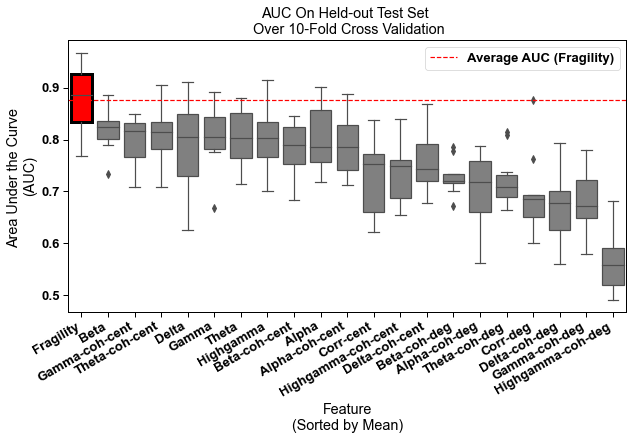

In [45]:
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['figure.titleweight'] = 'bold'

sns.set_context('paper', font_scale=1.5)
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(x='Feature', y='AUC', order=order.index,
            data=feature_aucs_df, ax=ax,
           color='gray')
ax.axhline(feature_aucs_df[feature_aucs_df['Feature'] == 'Fragility']['AUC'].mean(),
          color='red', ls='--', label='Average AUC (Fragility)')
xticklabels = ax.get_xticklabels()
ax.set_xticklabels(xticklabels, 
                   ha='right', rotation=30
                  )
ax.legend()
ax.set(title='AUC On Held-out Test Set \n Over 10-Fold Cross Validation',
      xlabel='Feature\n(Sorted by Mean)',
      ylabel='Area Under the Curve \n(AUC)')

# Select which box you want to change    
mybox = ax.artists[0]

# Change the appearance of that box
mybox.set_facecolor('red')
mybox.set_edgecolor('black')
mybox.set_linewidth(3)

figpath = Path(figdir) / f'figure4-discriminationandprecision/'
fname = f'delta_auc_plot_{clf_type}_quantilefeatures.pdf'
# fig.savefig(figpath / fname, bbox_inches='tight')
